In [12]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_score,
    recall_score, f1_score, roc_curve
)

from p2ch14.model1 import LunaModel
from p2ch14.dsets import LunaDataset

In [13]:
ds = p2ch14.dsets.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])
diam = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()
num_ben = len(is_mal) - num_mal

2025-07-17 10:01:32,780 INFO     pid:27964 p2ch14.dsets:279:__init__ <p2ch14.dsets.MalignantLunaDataset object at 0x000001A4A0AAC640>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


[pylidc] Loading malignancy info...
[pylidc] Loaded benign: 0, malignant: 0, negative: 549714


2025-07-17 09:59:31,836 INFO     pid:27964 p2ch14.dsets:279:__init__ <p2ch14.dsets.LunaDataset object at 0x000001A4A0A385B0>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio
100%|██████████| 6448/6448 [00:50<00:00, 128.79it/s]

[Confusion Matrix]
[[50811   618]
 [    4   150]]

[Classification Report]
              precision    recall  f1-score   support

           0     0.9999    0.9880    0.9939     51429
           1     0.1953    0.9740    0.3254       154

    accuracy                         0.9879     51583
   macro avg     0.5976    0.9810    0.6596     51583
weighted avg     0.9975    0.9879    0.9919     51583



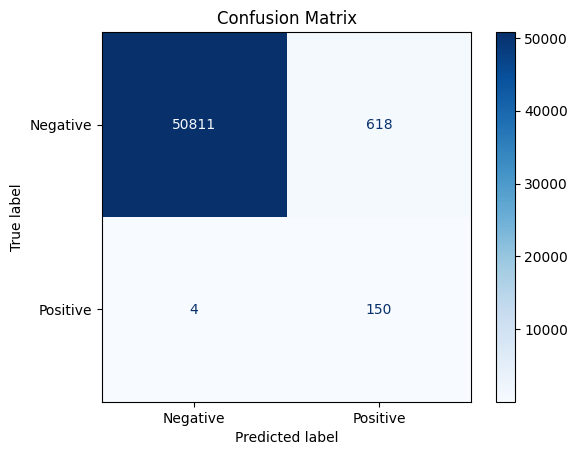


[INFO] 저장된 TP 결절 수: 150


In [ ]:
model = LunaModel()
device = torch.device("cuda")
model = model.to(device)
model_path = "data-unversioned/part2/models/p2ch14/resnet_2025-07-16_09.59.26_dlwpt.1500000.state"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.eval()

val_ds = LunaDataset(isValSet_bool=True, val_stride=10)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=0)

y_true = []
y_pred = []
y_prob = []
predicted_nodules = []

with torch.no_grad():
    for data, label, series_list, center_list, *_ in tqdm(val_loader):
        data = data.to(device)
        output = model(data)

        if isinstance(output, tuple):
            output = output[0]

        probs = F.softmax(output, dim=1).detach().cpu().numpy()
        labels = label.argmax(dim=1).cpu().numpy()
        preds = (probs[:, 1] > 0.5).astype(int)

        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        y_prob.extend(probs[:, 1].tolist())

        for prob_score, true_label, pred_label, series_uid, center_xyz in zip(
            probs[:, 1], labels, preds, series_list, center_list
        ):
            if true_label == 1 and pred_label == 1:
                predicted_nodules.append({
                    'series_uid': series_uid,
                    'center_xyz': center_xyz,
                    'probability': prob_score
                })

# 4. 혼동 행렬 출력
cm = confusion_matrix(y_true, y_pred)
print("[Confusion Matrix]")
print(cm)

print("\n[Classification Report]")
print(classification_report(y_true, y_pred, digits=4))

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# 5. TP 저장
with open("predicted_nodules_base.pkl", "wb") as f:
    pickle.dump(predicted_nodules, f)

print(f"\n saved TP nodule : {len(predicted_nodules)}")

In [ ]:
model = LunaModel()
device = torch.device("cuda")
model.load_state_dict(torch.load("data-unversioned/part2/models/p2ch14/resnet_2025-07-16_09.59.26_dlwpt.1500000.state", map_location=device)['model_state'])
model = model.to(device).eval()

val_ds = LunaDataset(isValSet_bool=True, val_stride=10)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=0)

predicted_nodules = []

with torch.no_grad():
    for data, label, _, series_list, center_list in tqdm(val_loader):
        data = data.to(device)
        output = model(data)

        if isinstance(output, tuple):
            output = output[0]

        probs = F.softmax(output, dim=1).detach().cpu().numpy()
        labels = label.argmax(dim=1).cpu().numpy()
        preds = (probs[:, 1] > 0.5).astype(int)

        for prob_score, true_label, pred_label, series_uid, center_xyz in zip(
            probs[:, 1], labels, preds, series_list, center_list
        ):
            # 🔒 여기서 series_uid는 이미 문자열 UID임 (수정 불필요)
            if true_label == 1 and pred_label == 1:
                predicted_nodules.append({
                    'series_uid': str(series_uid),  # 안전하게 문자열로 변환
                    'center_xyz': center_xyz.tolist(),  # numpy 호환
                    'probability': float(prob_score)
                })

with open("predicted_nodules_resnet.pkl", "wb") as f:
    pickle.dump(predicted_nodules, f)

print(f"save finish: {len(predicted_nodules)} True Positive")

2025-07-17 09:56:26,954 INFO     pid:27964 p2ch14.dsets:279:__init__ <p2ch14.dsets.LunaDataset object at 0x000001A28E5FC370>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio
100%|██████████| 6448/6448 [00:51<00:00, 124.51it/s]

[INFO] 저장 완료: 총 150개 True Positive


In [ ]:
# 1. 수정된 pickle 불러오기
with open("predicted_nodules_resnet.pkl", "rb") as f:
    predicted_nodules = pickle.load(f)

# 2. GT 로딩
anno_df = pd.read_csv("data/part2/luna/annotations_with_malignancy.csv")
anno_df = anno_df.rename(columns={'seriesuid': 'series_uid', 'mal_bool': 'malignancy'})
anno_df['series_uid'] = anno_df['series_uid'].astype(str).str.strip()

# 3. GT 딕셔너리화
gt_coords_by_uid = {}
for _, row in anno_df.iterrows():
    uid = row['series_uid']
    coord = (row['coordX'], row['coordY'], row['coordZ'])
    malignancy = row['malignancy']
    gt_coords_by_uid.setdefault(uid, []).append((coord, malignancy))

# 4. 매칭
output_rows = []

for pred in predicted_nodules:
    uid = pred['series_uid']
    prob = pred['probability']
    cx, cy, cz = pred['center_xyz'][:3]
    pred_xyz = np.array([[cx, cy, cz]])

    if uid not in gt_coords_by_uid:
        output_rows.append({
            'series_uid': uid,
            'centerX': cx,
            'centerY': cy,
            'centerZ': cz,
            'probability': prob,
            'matched': False,
            'malignancy': None
        })
        continue

    gt_coords = np.array([xyz for xyz, _ in gt_coords_by_uid[uid]])
    malignancies = [mal for _, mal in gt_coords_by_uid[uid]]
    distances = cdist(pred_xyz, gt_coords).flatten()
    min_idx = distances.argmin()
    matched_malignancy = malignancies[min_idx]

    output_rows.append({
        'series_uid': uid,
        'centerX': cx,
        'centerY': cy,
        'centerZ': cz,
        'probability': prob,
        'matched': True,
        'malignancy': matched_malignancy
    })

# 5. 저장
df_out = pd.DataFrame(output_rows)
df_out.to_csv("matched_and_unmatched.csv", index=False)

# 6. 통계
matched_df = df_out[df_out['matched']]
print(f"[Matched: {len(matched_df)} / {len(df_out)}]")
print(f"  ▸ 악성: {matched_df['malignancy'].sum()}")
print(f"  ▸ 양성: {(matched_df['malignancy'] == 0).sum()}")
print(f"  ▸ 매칭 실패: {len(df_out) - len(matched_df)}")

[Matched: 150 / 150]
  ▸ 악성: 58
  ▸ 양성: 92
  ▸ 매칭 실패: 0


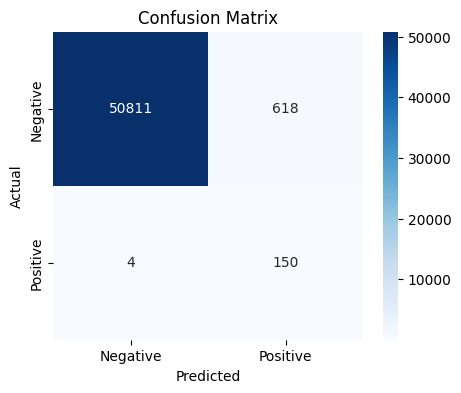

In [ ]:
y_pred = [1 if p > 0.5 else 0 for p in y_score]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()